# 案例分析二：二维平面运动轨迹的估计与预测

本 Notebook 是文章《深入浅出卡尔曼滤波》的配套实践案例二。

我们将为一个在二维平面上做近似恒速运动的目标构建并实现一个卡尔曼滤波器。通过这个过程，您将学习到：

1.  如何为多维系统（二维运动）建立状态空间模型，包括位置和速度。
2.  如何定义状态转移矩阵 `F`、观测矩阵 `H` 以及过程噪声 `Q` 和测量噪声 `R`。
3.  如何使用 `pykalman` 处理多维状态和观测数据。
4.  如何从带噪声的位置观测中，估计出平滑的轨迹以及未被直接观测到的速度分量。
5.  如何通过可视化来评估滤波和速度估计的效果。

## 环境与依赖项设置

在运行此 Notebook 之前，请确保您已在终端中激活相应的 Python 环境，并安装了必要的库。

```bash
# 激活您的 conda 环境 (例如 KF-test)
conda activate KF-test

# 安装核心依赖
conda install -y numpy matplotlib

# 安装 pykalman
conda install -y -c conda-forge pykalman
```

In [1]:
# 导入依赖
import os
try:
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib import font_manager as fm
    from pykalman import KalmanFilter
    print(f"numpy version: {np.__version__}")
    print(f"matplotlib version: {matplotlib.__version__}")
    print("pykalman library is available.")
except ImportError as e:
    print(f"依赖导入失败，请确认已正确安装 numpy, matplotlib, 和 pykalman: {e}")
    raise

numpy version: 1.26.4
matplotlib version: 3.3.2
pykalman library is available.


In [2]:
# 中文字体设置，用于在图表中正确显示中文
# 请将 _font_path 修改为您系统中SimHei或其他支持中文的字体文件路径
_font_path = r'./simhei.ttf' # 假设 simhei.ttf 在当前目录下
try:
    if os.path.exists(_font_path):
        fm.fontManager.addfont(_font_path)
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
        print(f'中文字体 SimHei 已从路径注册: {_font_path}')
    else:
        print(f'警告: 未在指定路径找到字体文件: {_font_path}，图表中的中文可能无法正常显示。')
except Exception as _e:
    print(f'注册自定义字体时发生错误: {_e}')

中文字体 SimHei 已从路径注册: ./simhei.ttf


## 步骤一：生成并可视化模拟数据

我们首先需要创建一个模拟的二维运动轨迹。这包括一个“完美的”真实轨迹（Ground Truth），以及在此基础上添加了高斯噪声的一系列位置观测点，用以模拟我们从传感器（如GPS）获得的实际数据。

数据已生成: N=200, dt=1.0, 测量噪声标准差=10.0


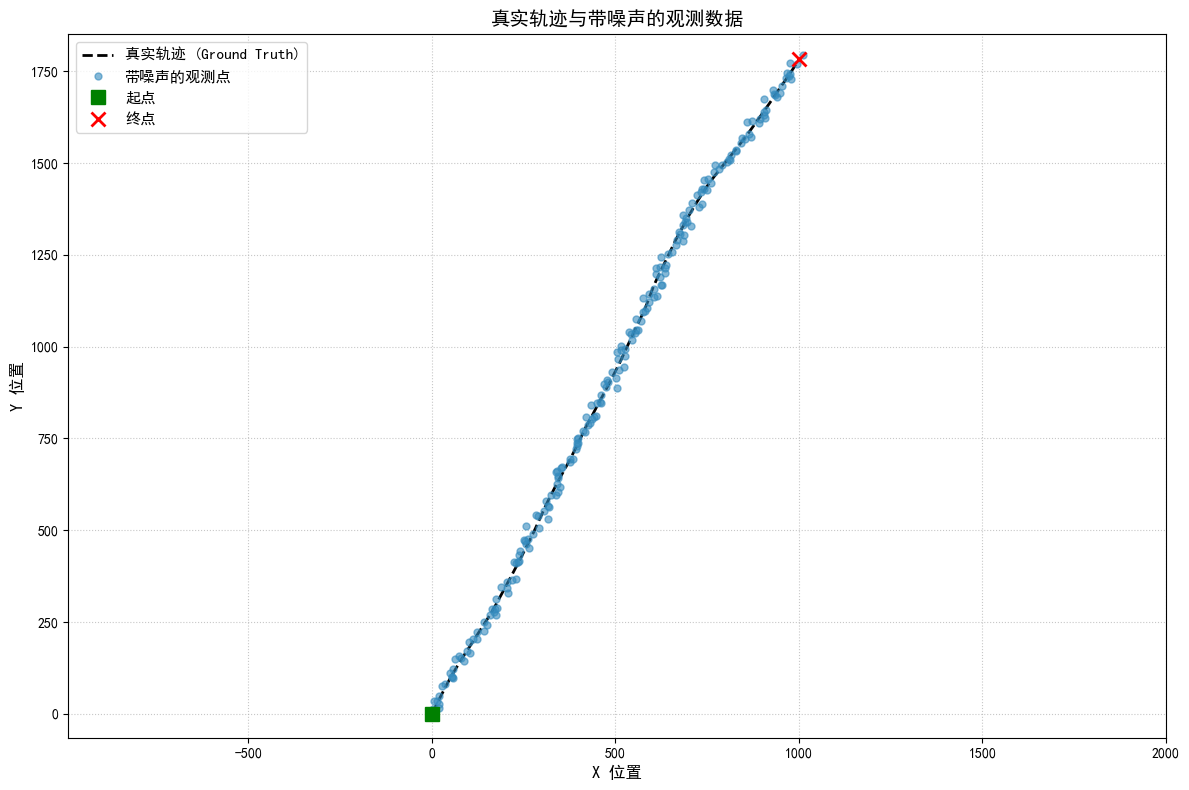

In [ ]:
# --- 数据生成参数 ---
rng = np.random.default_rng(42)  # 固定随机种子以保证结果可复现
N = 200                         # 数据点总数
dt = 1.0                        # 时间步长 (Δt)
accel_noise_std = 0.2           # 模拟真实运动中的随机加速度标准差
measurement_noise_std = 10.0      # 观测噪声的标准差 (σ_x 和 σ_y)

# --- 生成真实轨迹 (Ground Truth) ---
# 真实状态向量 x_true = [px, py, vx, vy]^T
x_true = np.zeros((N, 4))
x_true[0] = [0.0, 0.0, 5.0, 10.0]  # 初始状态：位置(0,0), 速度(5,10)

for t in range(1, N):
    # 状态转移
    px_prev, py_prev, vx_prev, vy_prev = x_true[t-1]

    # 引入随机加速度，使轨迹不完全是直线
    ax, ay = rng.normal(0, accel_noise_std, size=2)

    # 根据运动学公式更新状态
    vx_new = vx_prev + ax * dt
    vy_new = vy_prev + ay * dt
    px_new = px_prev + vx_prev * dt + 0.5 * ax * dt**2
    py_new = py_prev + vy_prev * dt + 0.5 * ay * dt**2

    x_true[t] = [px_new, py_new, vx_new, vy_new]

# --- 生成带噪声的观测值 ---
# 观测向量 z_obs = [px_measured, py_measured]^T
z_obs = x_true[:, :2] + rng.normal(0, measurement_noise_std, size=(N, 2))

print(f"数据已生成: N={N}, dt={dt}, 测量噪声标准差={measurement_noise_std:.1f}")

# --- 可视化生成的数据 ---
plt.figure(figsize=(12, 8))
plt.title("真实轨迹与带噪声的观测数据", fontsize=14)

# 绘制真实轨迹
plt.plot(x_true[:, 0], x_true[:, 1], color='k', linestyle='--', linewidth=2.0, label="真实轨迹 (Ground Truth)")

# 绘制带噪声的观测值
plt.plot(z_obs[:, 0], z_obs[:, 1], 'o', color='#348ABD', markersize=5, alpha=0.6, label="带噪声的观测点")

# 标记起点和终点
plt.plot(x_true[0, 0], x_true[0, 1], 'gs', markersize=10, label='起点')
plt.plot(x_true[-1, 0], x_true[-1, 1], 'rx', markersize=10, markeredgewidth=2, label='终点')

plt.xlabel("X 位置", fontsize=12)
plt.ylabel("Y 位置", fontsize=12)
plt.legend(loc="upper left", fontsize=11)
plt.grid(True, linestyle=':', alpha=0.7)
plt.axis('equal') # 保证X和Y轴的比例相同
plt.tight_layout()
plt.show()

## 步骤二：定义并初始化卡尔曼滤波器

在这一步，我们将根据文章中推导出的恒速（Constant Velocity）模型，定义卡尔曼滤波器所需的所有矩阵和初始参数。我们将使用 `pykalman` 库来构建滤波器对象。

In [ ]:
# --- 模型参数定义 ---
# 状态向量 x_k = [p_x, p_y, v_x, v_y]^T
# 观测向量 z_k = [p_x_measured, p_y_measured]^T

# 状态转移矩阵 F (基于恒速模型)
F = np.array([[1, 0, dt, 0 ],
              [0, 1, 0,  dt],
              [0, 0, 1,  0 ],
              [0, 0, 0,  1 ]])

# 观测矩阵 H (我们只能观测到位置)
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# --- 噪声协方差矩阵 (超参数) ---
# 过程噪声协方差 Q: 反映了模型(恒速)的不确定性，即目标机动的可能性。
sigma_a_sq = 0.5**2 # 假设加速度变化的方差 σ_a^2
Q_base = np.array([[(dt**4)/4, 0, (dt**3)/2, 0],
                     [0, (dt**4)/4, 0, (dt**3)/2],
                     [(dt**3)/2, 0, dt**2, 0],
                     [0, (dt**3)/2, 0, dt**2]])
Q = sigma_a_sq * Q_base

# 测量噪声协方差 R: 反映了观测值的不确定性。
# 理论上它应该约等于观测噪声的方差 (measurement_noise_std**2)，即 10.0**2 = 100。
R = np.eye(2) * measurement_noise_std**2

# --- 初始状态 ---
# 使用第一个观测值来初始化位置，并假设初始速度为零。
initial_state_mean = np.array([z_obs[0, 0], z_obs[0, 1], 0.0, 0.0])

# 初始误差协方差矩阵 P_0: 代表初始状态的不确定性。通常设为一个较大的对角矩阵。
initial_state_covariance = np.eye(4) * 500.0

# --- 使用 pykalman 构建滤波器 ---
kf = KalmanFilter(
    transition_matrices=F,
    observation_matrices=H,
    transition_covariance=Q,
    observation_covariance=R,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    n_dim_state=4, # 状态向量维度
    n_dim_obs=2    # 观测向量维度
)

# --- 执行滤波与平滑 ---
filtered_state_means, _ = kf.filter(z_obs)
smoothed_state_means, _ = kf.smooth(z_obs)

print("卡尔曼滤波与平滑计算完成。")
print(f"估计的状态维度: {smoothed_state_means.shape}")

卡尔曼滤波与平滑计算完成。
估计的状态维度: (200, 4)


## 步骤三：结果可视化与分析

现在，我们将所有结果绘制出来，直观地比较真实轨迹、带噪声的观测、滤波后的轨迹和平滑后的轨迹。我们还将特别关注卡尔曼滤波器对速度——这个我们从未直接观测到的隐藏状态——的估计能力。

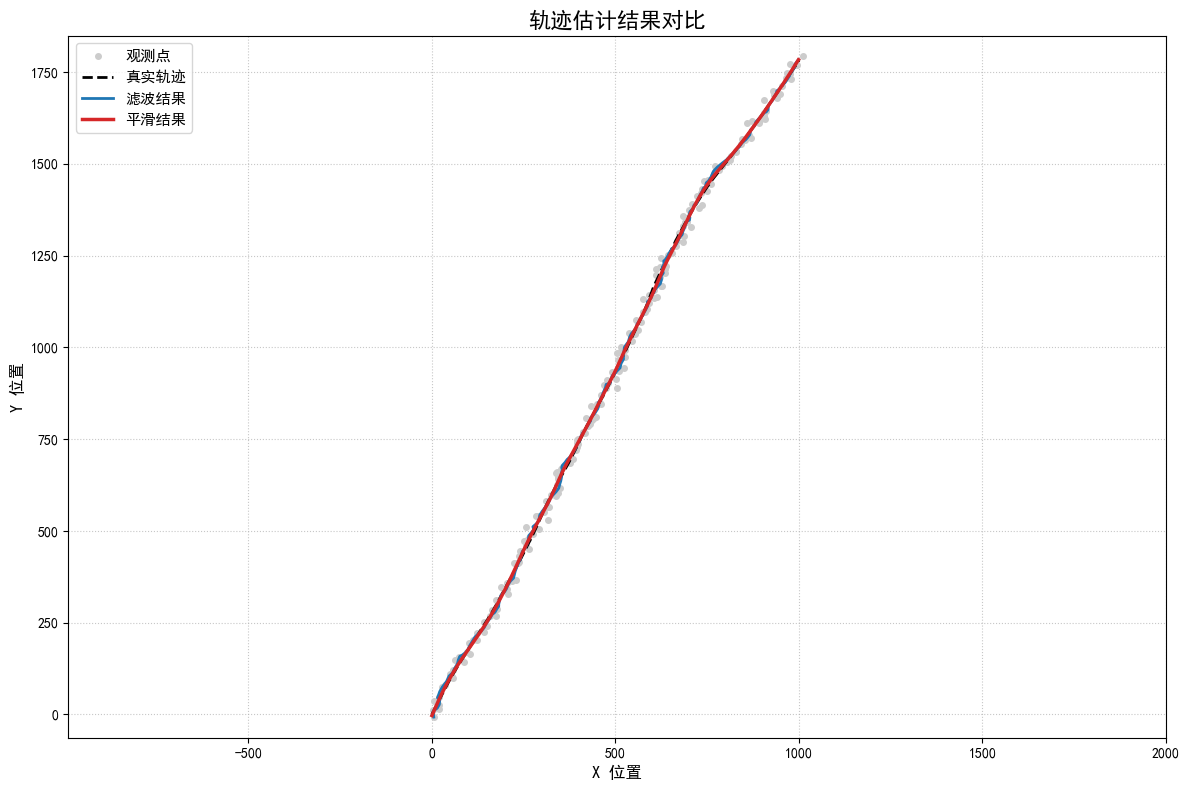

In [5]:
# --- 图1: 轨迹视图 (Y vs X) ---
plt.figure(figsize=(12, 8))
plt.title("轨迹估计结果对比", fontsize=16)

# 绘制观测点
plt.plot(z_obs[:, 0], z_obs[:, 1], 'o', color='#CCCCCC', markersize=4, label="观测点")

# 绘制真实轨迹
plt.plot(x_true[:, 0], x_true[:, 1], color='k', linestyle='--', linewidth=2.0, label="真实轨迹")

# 绘制滤波结果
plt.plot(filtered_state_means[:, 0], filtered_state_means[:, 1], color='#1f77b4', linestyle='-', linewidth=2.0, label="滤波结果")

# 绘制平滑结果 (通常效果最好)
plt.plot(smoothed_state_means[:, 0], smoothed_state_means[:, 1], color='#d62728', linestyle='-', linewidth=2.5, label="平滑结果")

plt.xlabel("X 位置", fontsize=12)
plt.ylabel("Y 位置", fontsize=12)
plt.legend(loc="upper left", fontsize=11)
plt.grid(True, linestyle=':', alpha=0.7)
plt.axis('equal')
plt.tight_layout()
plt.show()

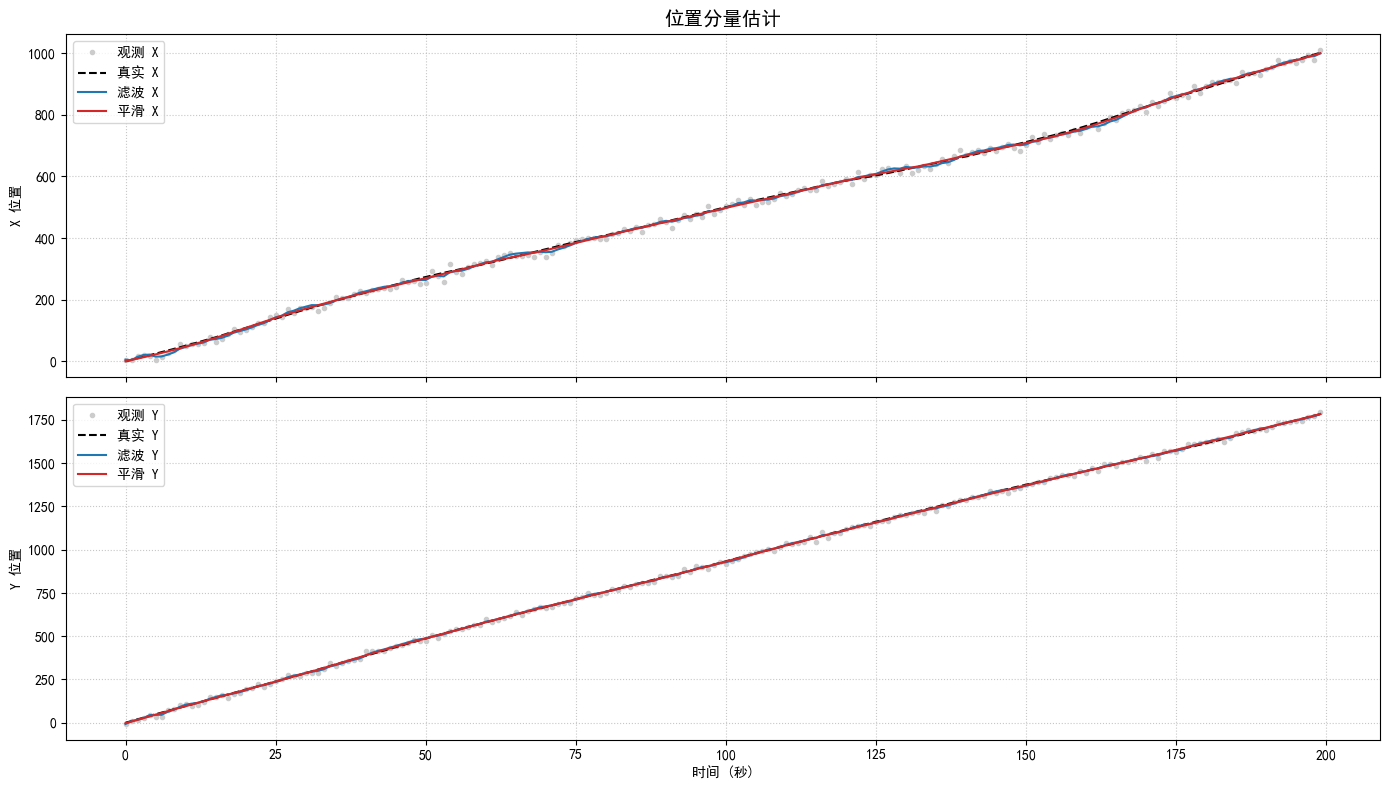

In [6]:
# --- 图2: 位置分量 vs 时间 ---
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
time_axis = np.arange(N) * dt

# X 位置
axes[0].plot(time_axis, z_obs[:, 0], 'o', color='#CCCCCC', markersize=3, label='观测 X')
axes[0].plot(time_axis, x_true[:, 0], 'k--', label='真实 X')
axes[0].plot(time_axis, filtered_state_means[:, 0], color='#1f77b4', label='滤波 X')
axes[0].plot(time_axis, smoothed_state_means[:, 0], color='#d62728', label='平滑 X')
axes[0].set_ylabel("X 位置")
axes[0].set_title("位置分量估计", fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle=':', alpha=0.7)

# Y 位置
axes[1].plot(time_axis, z_obs[:, 1], 'o', color='#CCCCCC', markersize=3, label='观测 Y')
axes[1].plot(time_axis, x_true[:, 1], 'k--', label='真实 Y')
axes[1].plot(time_axis, filtered_state_means[:, 1], color='#1f77b4', label='滤波 Y')
axes[1].plot(time_axis, smoothed_state_means[:, 1], color='#d62728', label='平滑 Y')
axes[1].set_xlabel("时间 (秒)")
axes[1].set_ylabel("Y 位置")
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

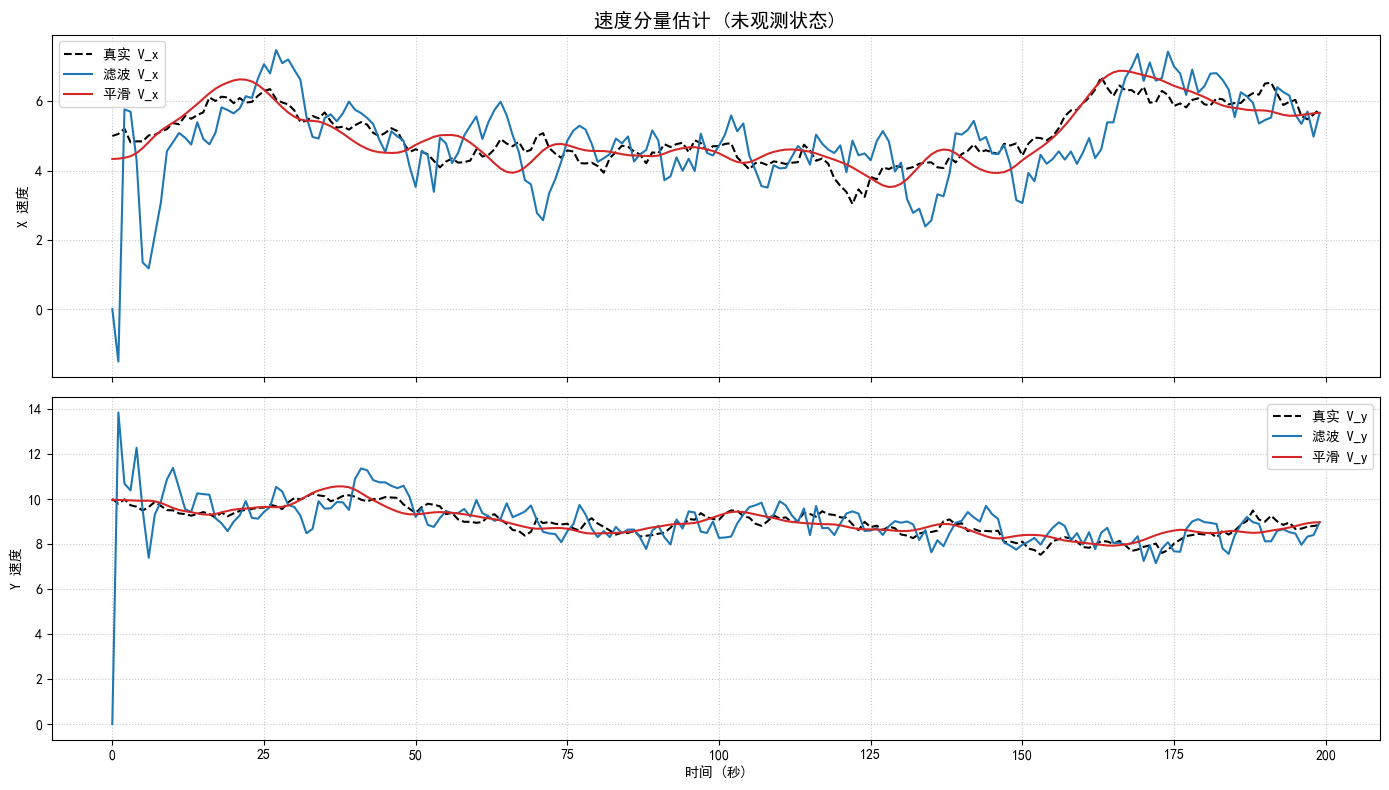

In [7]:
# --- 图3: 速度分量 vs 时间 ---
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
time_axis = np.arange(N) * dt

# X 速度
axes[0].plot(time_axis, x_true[:, 2], 'k--', label='真实 V_x')
axes[0].plot(time_axis, filtered_state_means[:, 2], color='#1f77b4', label='滤波 V_x')
axes[0].plot(time_axis, smoothed_state_means[:, 2], color='#d62728', label='平滑 V_x')
axes[0].set_ylabel("X 速度")
axes[0].set_title("速度分量估计 (未观测状态)", fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle=':', alpha=0.7)

# Y 速度
axes[1].plot(time_axis, x_true[:, 3], 'k--', label='真实 V_y')
axes[1].plot(time_axis, filtered_state_means[:, 3], color='#1f77b4', label='滤波 V_y')
axes[1].plot(time_axis, smoothed_state_means[:, 3], color='#d62728', label='平滑 V_y')
axes[1].set_xlabel("时间 (秒)")
axes[1].set_ylabel("Y 速度")
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

## 总结与探索

至此，我们完成了对二维运动轨迹的卡尔曼滤波全过程。从可视化结果中可以清晰地看到：

- **轨迹估计**：平滑（红色）和滤波（蓝色）后的轨迹都显著地去除了观测点（灰色）中的噪声，生成了一条更符合物理运动规律的平滑路径。平滑结果由于利用了所有数据，通常最接近真实轨迹（黑色虚线）。
- **隐藏状态估计**：最令人印象深刻的是，尽管我们从未直接测量过速度，卡尔曼滤波器成功地从一系列有噪声的位置数据中估计出了目标的速度分量（$V_x$ 和 $V_y$）。平滑后的速度估计曲线与真实速度非常吻合。

这充分展示了卡尔曼滤波器作为一种强大的状态估计工具的能力，尤其是在处理多维系统和估计不可直接观测的变量方面。

现在，您可以返回到“步骤二：定义并初始化卡尔曼滤波器”单元格，尝试调整过程噪声协方差 `Q` (通过 `sigma_a_sq`) 和测量噪声协方差 `R` 的值，然后重新运行所有单元格，观察它们如何影响最终的滤波效果。

- **增大 `Q`**：相当于告诉滤波器“模型（恒速）不可靠，目标可能随时剧烈机动”。这会使滤波器更多地信任新的观测值，导致滤波轨迹对噪声更敏感，但能更快地响应真实轨迹的突然变化。
- **增大 `R`**：相当于告诉滤波器“观测值非常不准”。这会使滤波器更多地信任模型的预测，导致滤波轨迹更平滑，但对观测值的响应会变慢。